In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [44]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Import Data

In [45]:
df = pd.read_csv("/content/drive/MyDrive/PORTOFOLIO/data/taxi_fare.csv", parse_dates=["pickup_datetime"])
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1.0
1,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1.0
2,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2.0
3,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1.0
4,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1.0


In [46]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      1
dtype: int64

In [47]:
df.dropna(inplace=True)

In [48]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

# Extrac Time Feature

In [49]:
pickup_dt = df.pickup_datetime.dt

In [50]:
df["year"] = pickup_dt.year
df["mont"] = pickup_dt.month
df["day"] = pickup_dt.day_of_week
df["hour"] = pickup_dt.hour
df.drop(columns="pickup_datetime", inplace=True)
df.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,mont,day,hour
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,2009,6,0,17
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,2010,1,1,16
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,2011,8,3,0
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,2012,4,5,4
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,2010,3,1,7


# Extract Distance Feature

In [51]:
df["distance"] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude)
df.drop(columns=["pickup_longitude", "dropoff_longitude", "pickup_latitude", "dropoff_latitude"], inplace=True)
df.head()

,fare_amount,passenger_count,year,mont,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


# Dataset Splitting

In [52]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

In [53]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

In [54]:
# Define functions for numeric and categorical preprocessing
def num_pipe(poly_degree=2):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=poly_degree)),
    ])

def cat_pipe():
    return Pipeline([
        ('onehot', OneHotEncoder(sparse=False)),
    ])

# Define a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(), ['mont', 'day', 'hour']),
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# Define grid search parameters
param_grid = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'prep__numeric__poly__interaction_only': [True, False],
    'algo__fit_intercept': [True, False]
}

# Create GridSearchCV model
model = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='r2')
model.fit(X_train, y_train)

# Print the best parameters and scores
print("Best Parameters:", model.best_params_)
print("Training Score:", model.score(X_train, y_train))
print("Validation Score (Best Score):", model.best_score_)
print("Test Score:", model.score(X_test, y_test))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Best Parameters: {'algo__fit_intercept': True, 'prep__numeric__poly__degree': 1, 'prep__numeric__poly__interaction_only': True}
Training Score: 0.023086823745762874
Validation Score (Best Score): 0.015619219341358312
Test Score: 0.019169174589703797


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


# Feature Importance
jangan lakukan feature importance karena score nya masih parah

# Evaluation

## Actual vs Prediction Plot

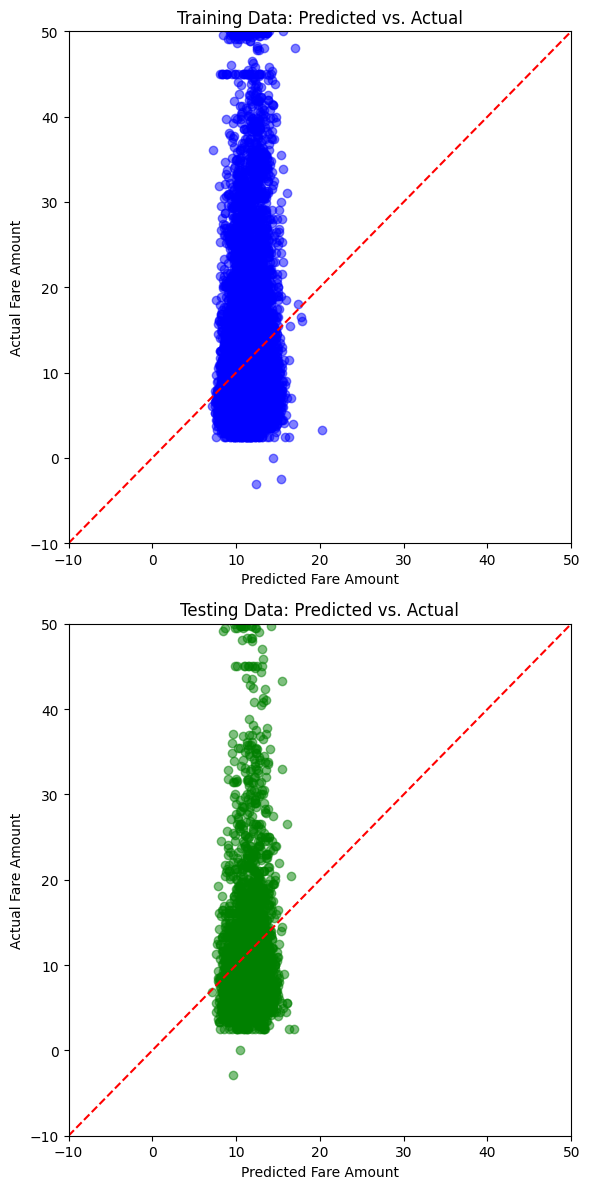

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model):
    # Predict the values on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate the accuracy (MAE, MSE, RMSE)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_rmse = np.sqrt(train_mse)

    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_rmse = np.sqrt(test_mse)

    # Create scatter plots for training and testing data
    plt.figure(figsize=(6, 12))

    # Set the axis limits to 0-50
    axis_limits = [-10, 50]

    # Training data
    plt.subplot(2, 1, 1)
    plt.scatter(y_train_pred, y_train, color='blue', alpha=0.5)
    plt.plot(axis_limits, axis_limits, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Actual Fare Amount')
    plt.title(f'Training Data: Predicted vs. Actual')
    plt.xlim(axis_limits)
    plt.ylim(axis_limits)

    # Testing data
    plt.subplot(2, 1, 2)
    plt.scatter(y_test_pred, y_test, color='green', alpha=0.5)
    plt.plot(axis_limits, axis_limits, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Actual Fare Amount')
    plt.title(f'Testing Data: Predicted vs. Actual')
    plt.xlim(axis_limits)
    plt.ylim(axis_limits)

    plt.tight_layout()
    plt.show()

# Call the function to plot actual vs. predicted values with accuracy and diagonal line
plot_actual_vs_prediction(X_train, y_train, X_test, y_test, model)


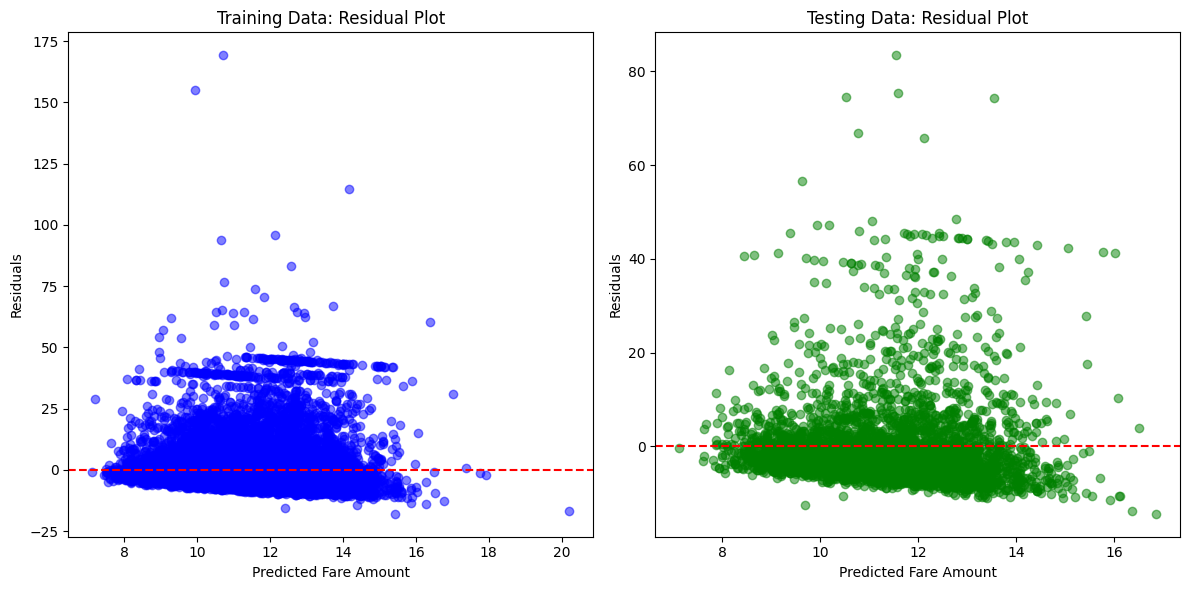

In [58]:
def plot_residual(X_train, y_train, X_test, y_test, model):
    # Calculate residuals on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Create residual plots for training and testing data
    plt.figure(figsize=(12, 6))

    # Training data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, train_residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Residuals')
    plt.title('Training Data: Residual Plot')

    # Testing data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, test_residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Residuals')
    plt.title('Testing Data: Residual Plot')

    plt.tight_layout()
    plt.show()

# Call the function to plot residual plots
plot_residual(X_train, y_train, X_test, y_test, model)


# Coba menggunakan Transformer yeo-johnson

In [59]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

In [60]:
# Define functions for numeric and categorical preprocessing
def num_pipe(poly_degree=2):
    return Pipeline([
        ('poly', PolynomialFeatures(degree=poly_degree)),
        ('transform', PowerTransformer(method='yeo-johnson', standardize=True)),
    ])

def cat_pipe():
    return Pipeline([
        ('onehot', OneHotEncoder(sparse=False)),
    ])

# Define a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['passenger_count', 'year', 'distance']),
    ('categoric', cat_pipe(), ['mont', 'day', 'hour']),
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LinearRegression())
])

# Define grid search parameters
param_grid = {
    'prep__numeric__poly__degree': [1, 2, 3],
    'algo__fit_intercept': [True, False]
}

# Create GridSearchCV model
model = GridSearchCV(pipeline, param_grid, cv=3, n_jobs=-1, verbose=1)
model.fit(X_train, y_train)

# Print the best parameters and scores
print("Best Parameters:", model.best_params_)
print("Training Score:", model.score(X_train, y_train))
print("Validation Score (Best Score):", model.best_score_)
print("Test Score:", model.score(X_test, y_test))

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Parameters: {'algo__fit_intercept': False, 'prep__numeric__poly__degree': 2}
Training Score: 0.7157250233130596
Validation Score (Best Score): 0.7126723888513764
Test Score: 0.7389258251123004


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


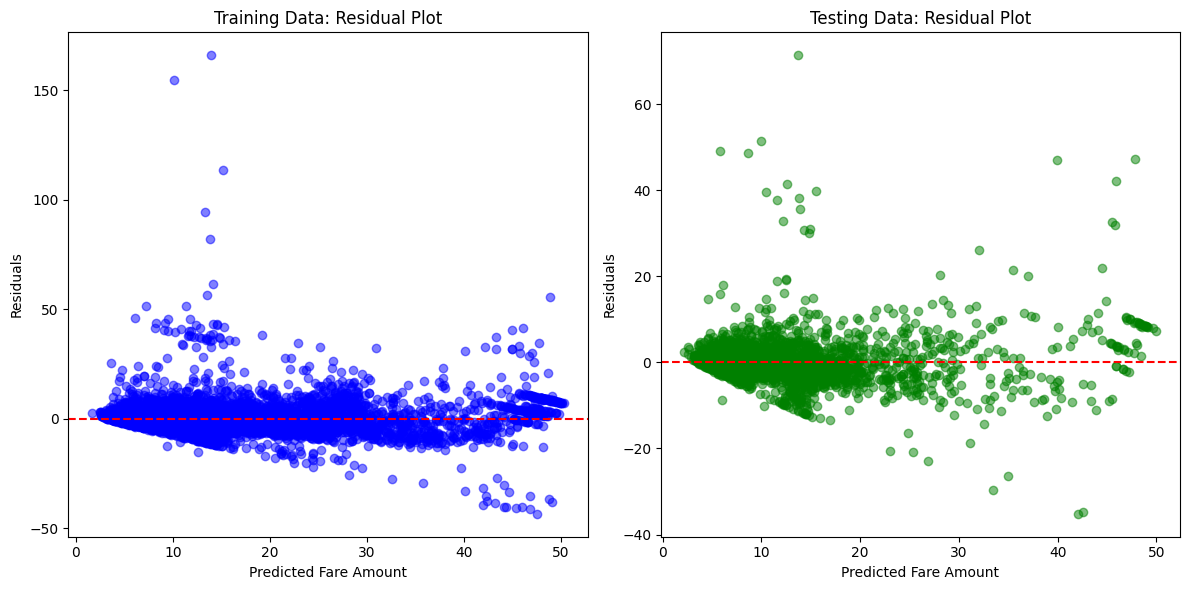

In [61]:
def plot_residual(X_train, y_train, X_test, y_test, model):
    # Calculate residuals on training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    train_residuals = y_train - y_train_pred
    test_residuals = y_test - y_test_pred

    # Create residual plots for training and testing data
    plt.figure(figsize=(12, 6))

    # Training data
    plt.subplot(1, 2, 1)
    plt.scatter(y_train_pred, train_residuals, color='blue', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Residuals')
    plt.title('Training Data: Residual Plot')

    # Testing data
    plt.subplot(1, 2, 2)
    plt.scatter(y_test_pred, test_residuals, color='green', alpha=0.5)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Fare Amount')
    plt.ylabel('Residuals')
    plt.title('Testing Data: Residual Plot')

    plt.tight_layout()
    plt.show()

# Call the function to plot residual plots
plot_residual(X_train, y_train, X_test, y_test, model)